# Anomaly Detection with PaDiM

## Introduction
In industrial settings, the occurrence of defects or anomalies is often infrequent, but their detection is crucial for maintaining quality and operational standards. Traditional supervised learning approaches require large amounts of labeled data, which is impractical to collect and annotate for rare defect types. This notebook introduces the use of the PaDiM (Patch Distribution Modeling) framework, an unsupervised anomaly detection technique that addresses this challenge effectively.

PaDiM is particularly valuable for scenarios where anomalies are sparse and varied, making manual dataset compilation both time-consuming and challenging. By leveraging a model trained on normal samples without the need for anomaly-labeled data, PaDiM can detect subtle deviations from the norm, highlighting potential defects. This approach not only saves significant time and effort in dataset preparation but also enhances the ability to identify unseen types of anomalies.

This notebook will guide through the implementation of PaDiM using the "Decospan fineerplaten dataset". It will cover the setup, training, and evaluation stages, providing a comprehensive tool for initiating anomaly detection in environments where anomalies are rare yet critical to detect.



## Imports



In [ ]:
from anomalib.data.folder import Folder
from anomalib.data.task_type import TaskType
from anomalib.data.utils import read_image
from anomalib.data import InferenceDataset
from anomalib.data.mvtec import MVTec
from anomalib.deploy import OpenVINOInferencer
from anomalib.models import Padim, Fastflow
from anomalib.post_processing import (
    NormalizationMethod,
    ThresholdMethod,
    superimpose_anomaly_map,
    Visualizer,
    VisualizationMode
)
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import (
    ImageVisualizerCallback,
    MetricsConfigurationCallback,
    MetricVisualizerCallback,
    PostProcessingConfigurationCallback,
    ExportCallback,
    ExportMode,
    MinMaxNormalizationCallback
)
from functools import partial, update_wrapper
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.optim import Optimizer
from torch.optim.adam import Adam
from torch.utils.data import DataLoader
import os


## Configurable variables

In [ ]:
model_name = "padim" 

# Input directory
input_directory = "dataset"
fault_dir = "fault"
bg_dir = "bg"

# Training settings
split_ratio = 0.2
batch_size = 32
patch_size = 480

## Dataset definition

In [ ]:
datamodule = Folder(
    root=input_directory,
    normal_dir=bg_dir,
    abnormal_dir=fault_dir,
    normal_split_ratio=split_ratio,
    image_size=(patch_size, patch_size),
    train_batch_size=batch_size,
    eval_batch_size=batch_size,
    task=TaskType.CLASSIFICATION,
)
datamodule.setup()  # Split the data to train/val/test/prediction sets.
datamodule.prepare_data()  # Create train/val/test/predic dataloaders

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

## Training

In [ ]:
#Deine padim model
model = Padim(
    input_size=(256, 256),
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3"],
)

# Create output path directory
Path('weights/openvino/padim').mkdir(parents=True, exist_ok=True)

callbacks = [
    MetricsConfigurationCallback(
        task=TaskType.CLASSIFICATION,
        image_metrics=["AUROC"], # tried other metrics, but gave errors
    ),
    ModelCheckpoint(
        mode="max",
        monitor="image_AUROC",
    ),
    PostProcessingConfigurationCallback(
        normalization_method=NormalizationMethod.MIN_MAX,
        threshold_method=ThresholdMethod.ADAPTIVE,
    ),
    MinMaxNormalizationCallback(),

    ExportCallback(
        input_size=(224, 224),
        dirpath=str(Path.cwd())+"/"+model_name,
        filename="output",
        export_mode=ExportMode.OPENVINO,
    ),
    ]

trainer = Trainer(
        callbacks=callbacks,
        accelerator="auto",
        auto_scale_batch_size=False,
        check_val_every_n_epoch=1,
        devices=1,
        gpus=None,
        max_epochs=1,
        num_sanity_val_steps=0,
        val_check_interval=1.0,
    )
trainer.fit(model, datamodule=datamodule)

## Test inference

In [5]:
directory = model_name + '_test_output/'

# Create the directory if it doesn't exist and clear all files in the directory
Path(directory).mkdir(parents=True, exist_ok=True)
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.remove(file_path)
print("All files in 'test_output' have been cleared.")

# Load the inference engine
openvino_model_path = Path.cwd() / model_name / "weights" / "openvino" / "model.bin"
metadata_path = Path.cwd() / model_name / "weights" / "openvino" / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  # NVIDIA GPU not supported
)

# Initialize metrics
total_images = 0
true_positives = 0
false_positives = 0
false_negatives = 0
correct_predictions = 0

# Process images from the dataloader
for _, data in enumerate(datamodule.test_dataloader()):
    for path in data['image_path']:
        total_images += 1
        true_lbl = "bg"
        pred_lbl = "bg"
        confidence = 0

        image = read_image(path=path)
        predictions = inferencer.predict(image=image)
        confidence = predictions.pred_score
        
        if "bg" not in path:
            true_lbl = "faulty"
        if predictions.pred_label == True:
            pred_lbl = "faulty"
            if true_lbl == "faulty":
                true_positives += 1
            else:
                false_positives += 1
        else:
            if true_lbl == "faulty":
                false_negatives += 1

        if true_lbl == pred_lbl:
            correct_predictions += 1

# Calculate and print summary metrics
accuracy = correct_predictions / total_images if total_images > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
print("SUMMARY for model:", model_name)
print(f"Total images: {total_images}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")


All files in 'test_output' have been cleared.
True True
SUMMARY: padim_18
Total images: 1770
Accuracy: 0.89
Recall: 0.95
Precision: 0.92


## Load a Test Image

Let's read an image from the test set and perform inference using OpenVINO inferencer.

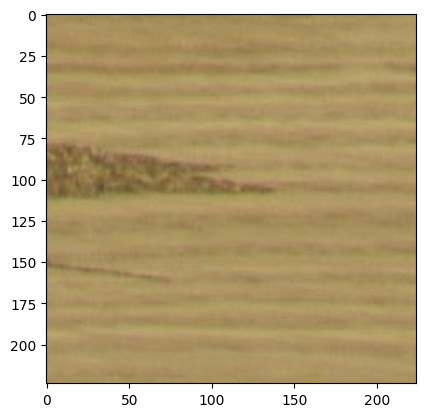

In [9]:
image = read_image(path="./dataset/fault/PO22-20488_10_1_annotated_3060_5040_3284_5264.png+fault.jpg")
plt.imshow(image)

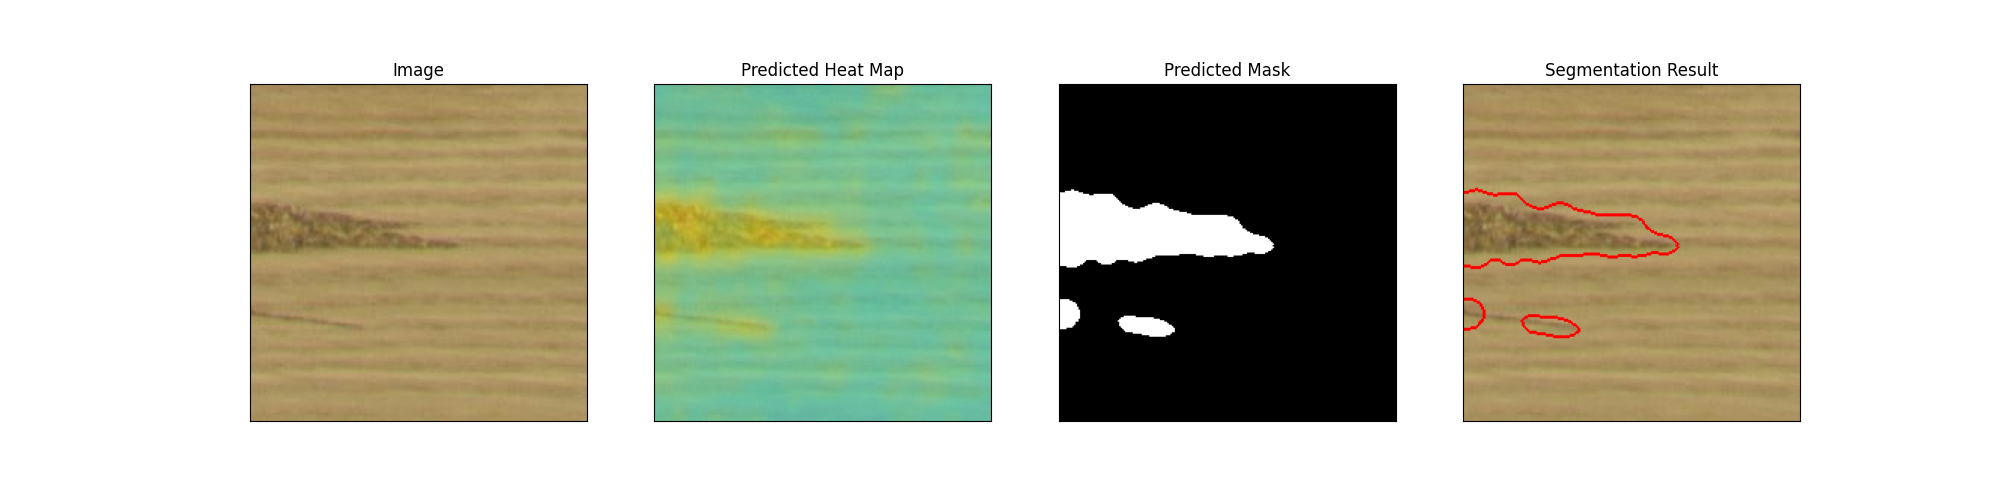

In [14]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,
    metadata=metadata_path,
    device="CPU",
)

predictions = inferencer.predict(image=image)
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)